E:\_SoftEng\_BeCode\real-estate-price-predictor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TEST_MODE is ON – running in test mode (reduced data, fewer trials).


[I 2025-06-29 14:22:16,356] A new study created in memory with name: no-name-6bb1713e-083b-49e4-9ca0-bd13254cc6d9


[I 2025-06-29 14:22:25,537] Trial 0 finished with value: 97897.36098909921 and parameters: {'iterations': 635, 'depth': 6, 'learning_rate': 0.03634846059297503, 'l2_leaf_reg': 0.001098611907156422, 'bagging_temperature': 0.6291882197867258, 'random_strength': 0.8502709577677272}. Best is trial 0 with value: 97897.36098909921.


[I 2025-06-29 14:22:46,799] Trial 1 finished with value: 94496.17085220423 and parameters: {'iterations': 574, 'depth': 9, 'learning_rate': 0.2275986108175491, 'l2_leaf_reg': 1.2030153431394552, 'bagging_temperature': 0.9782436714539492, 'random_strength': 0.8169805526295877}. Best is trial 1 with value: 94496.17085220423.


[I 2025-06-29 14:22:52,361] Trial 2 finished with value: 94478.16956240685 and parameters: {'iterations': 378, 'depth': 6, 'learning_rate': 0.1628727342217176, 'l2_leaf_reg': 0.26047435500503974, 'bagging_temperature': 0.8710496668254999, 'random_strength': 0.7553333414331811}. Best is trial 2 with value: 94478.16956240685.


[I 2025-06-29 14:22:53,491] A new study created in memory with name: no-name-bbedd967-04bf-4964-8045-14c032a8aa85


[I 2025-06-29 14:23:00,020] Trial 0 finished with value: 95585.52432932057 and parameters: {'iterations': 597, 'depth': 5, 'learning_rate': 0.1540091609558974, 'l2_leaf_reg': 6.703396725669818, 'bagging_temperature': 0.502517149881921, 'random_strength': 0.06590729313767607}. Best is trial 0 with value: 95585.52432932057.


[I 2025-06-29 14:23:07,977] Trial 1 finished with value: 95548.89928506443 and parameters: {'iterations': 664, 'depth': 5, 'learning_rate': 0.19507316010376302, 'l2_leaf_reg': 6.187885594674206, 'bagging_temperature': 0.9085508729700392, 'random_strength': 0.9256911182731984}. Best is trial 1 with value: 95548.89928506443.


[I 2025-06-29 14:23:15,086] Trial 2 finished with value: 97298.54971419221 and parameters: {'iterations': 316, 'depth': 8, 'learning_rate': 0.23979638448423005, 'l2_leaf_reg': 0.004532732450277165, 'bagging_temperature': 0.32342566684034446, 'random_strength': 0.864780749095051}. Best is trial 1 with value: 95548.89928506443.


Evaluation – CatBoost + Optuna CV (All Features)
  MAE:  51,719.81 €
  RMSE: 73,206.37 €
  R²:   0.8772
----------------------------------------
Evaluation – CatBoost + Optuna CV (Top RF Features)
  MAE:  53,774.71 €
  RMSE: 76,478.44 €
  R²:   0.8660
----------------------------------------
[✓] Model evaluation for 'CatBoost + Optuna CV (All Features)' logged.
[✓] Model evaluation for 'CatBoost + Optuna CV (Top RF Features)' logged.
Evaluation Summary (All Features):
=== Model Evaluation Summary ===


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,type,rank_r2,rmse/mae,best
0,162,2025-06-29 14:20:14,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,Linear Regression (All Features),202506291419,76 898.76 €,109 935.46 €,0.723000,Linear,6,1.430000,
1,163,2025-06-29 14:20:43,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,Random Forest (All Features),202506291419,68 324.02 €,101 428.25 €,0.764200,Tree,4,1.480000,
2,164,2025-06-29 14:20:53,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,Random Forest (Top 10 Features),202506291419,71 734.61 €,106 140.03 €,0.741800,Tree,5,1.480000,
3,165,2025-06-29 14:22:04,XGBoost + Optuna CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost with Optuna (All Features) [TEST],202506291419,3 891.83 €,7 847.80 €,0.998600,Boosting,1,2.020000,✓
4,166,2025-06-29 14:22:04,XGBoost + Optuna CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost with Optuna (Top RF Features) [TEST],202506291419,54 915.96 €,77 673.21 €,0.861800,Boosting,3,1.410000,
5,167,2025-06-29 14:23:16,CatBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,CatBoost with Optuna (All Features),202506291419,51 719.81 €,73 206.37 €,0.877200,Boosting,2,1.420000,



👉 Best model based on R²: XGBoost + Optuna CV (All Features) [TEST] ✓
Evaluation Summary (Top RF Features):
=== Model Evaluation Summary ===


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,type,rank_r2,rmse/mae,best
0,162,2025-06-29 14:20:14,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,Linear Regression (All Features),202506291419,76 898.76 €,109 935.46 €,0.723000,Linear,7,1.430000,
1,163,2025-06-29 14:20:43,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,Random Forest (All Features),202506291419,68 324.02 €,101 428.25 €,0.764200,Tree,5,1.480000,
2,164,2025-06-29 14:20:53,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,Random Forest (Top 10 Features),202506291419,71 734.61 €,106 140.03 €,0.741800,Tree,6,1.480000,
3,165,2025-06-29 14:22:04,XGBoost + Optuna CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost with Optuna (All Features) [TEST],202506291419,3 891.83 €,7 847.80 €,0.998600,Boosting,1,2.020000,✓
4,166,2025-06-29 14:22:04,XGBoost + Optuna CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost with Optuna (Top RF Features) [TEST],202506291419,54 915.96 €,77 673.21 €,0.861800,Boosting,4,1.410000,
5,167,2025-06-29 14:23:16,CatBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,CatBoost with Optuna (All Features),202506291419,51 719.81 €,73 206.37 €,0.877200,Boosting,2,1.420000,
6,168,2025-06-29 14:23:16,CatBoost + Optuna CV (Top RF Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,CatBoost with Optuna (Top RF Features),202506291419,53 774.71 €,76 478.44 €,0.866000,Boosting,3,1.420000,



👉 Best model based on R²: XGBoost + Optuna CV (All Features) [TEST] ✓
Diagnostics (All Features):


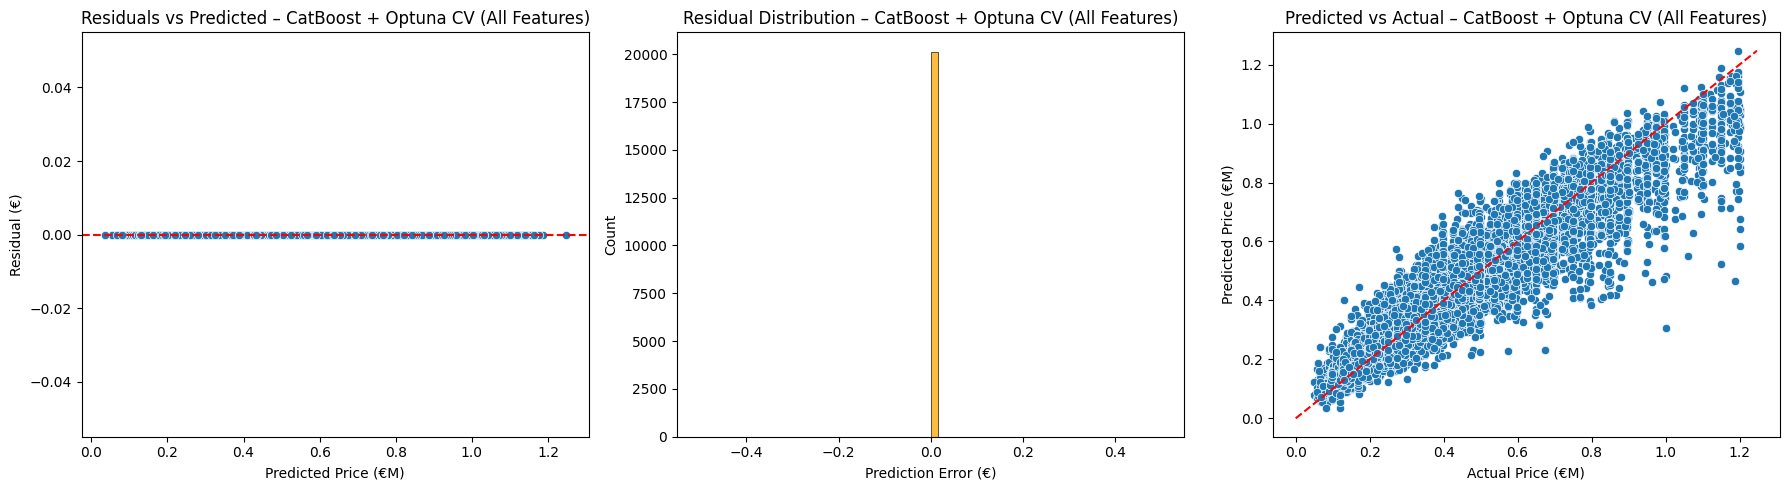

Diagnostics (Top RF Features):


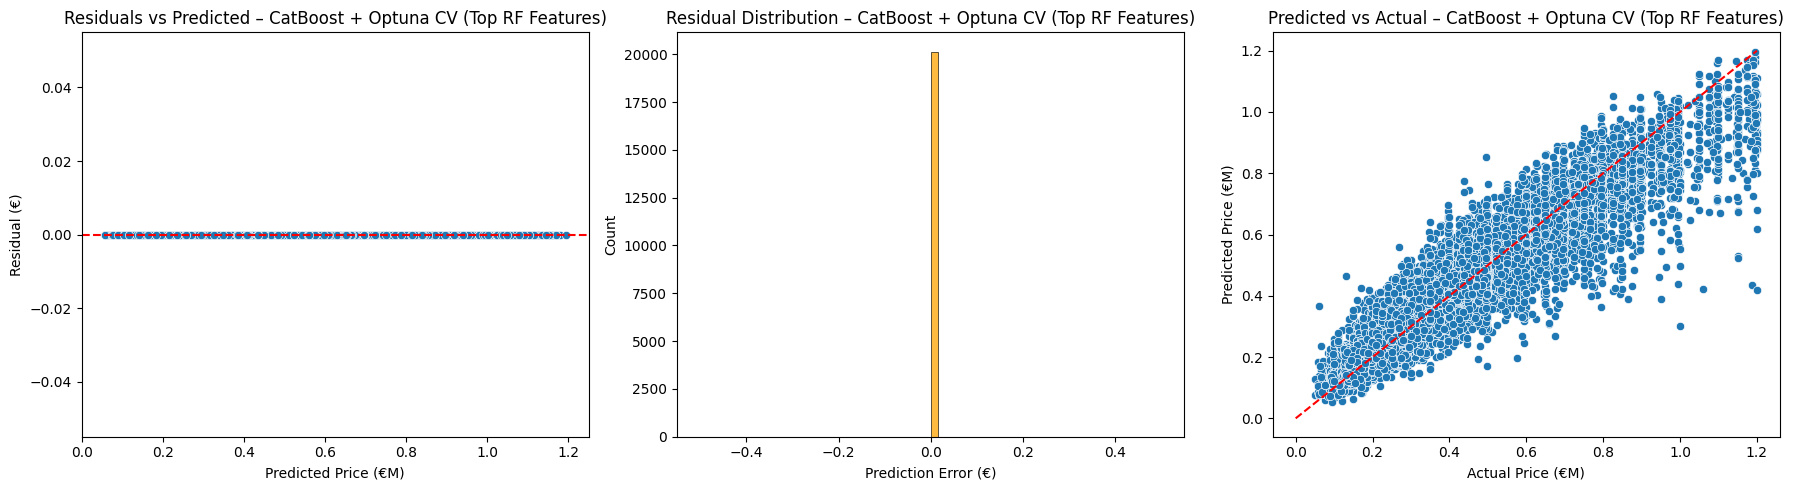

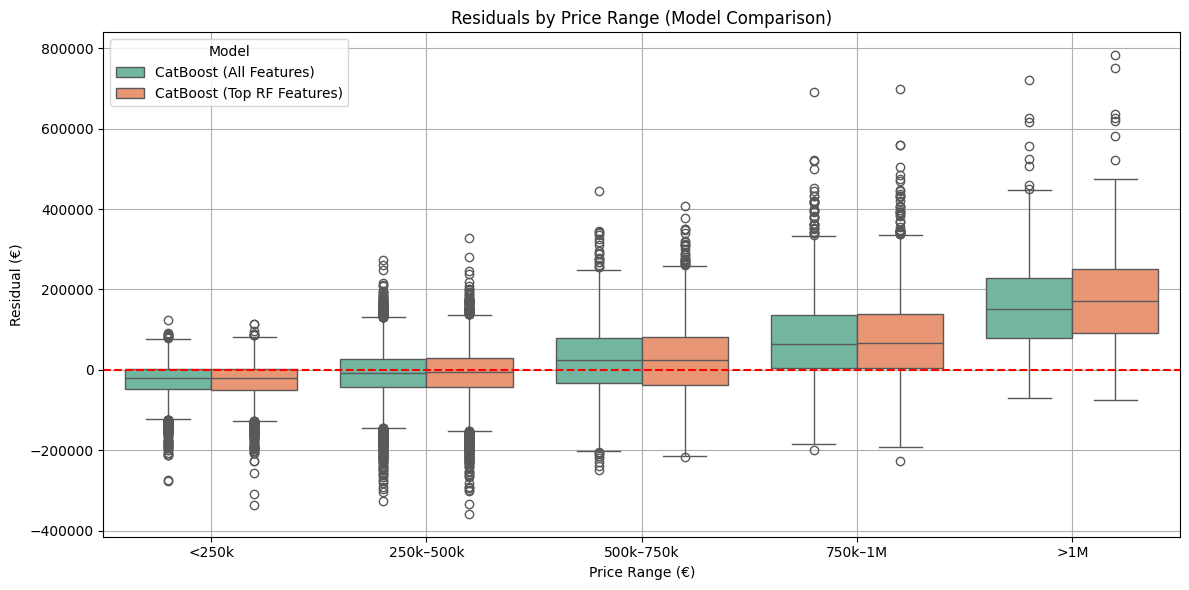

'\nModelEvaluator.plot_shap_comparison_beeswarm(\n    model_all=model_all,\n    x_all=X_reduced,\n    model_top=model_top,\n    x_top=X_top\n)\n'

In [1]:
import sys, os

# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root) 

import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error
from utils.constants import ML_READY_DATA_FILE, TEST_MODE
from utils.data_loader import DataLoader
from utils.model_evaluator import ModelEvaluator
from utils.experiment_tracker import ExperimentTracker
from utils.model_visualizer import ModelVisualizer


def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
 

if TEST_MODE:
    print("TEST_MODE is ON – running in test mode (reduced data, fewer trials).")
else:
    print("TEST_MODE is OFF – full training is active.")


# Step 1: Load and clean dataset
loader = DataLoader(ML_READY_DATA_FILE)
df = loader.load_data()
X = df.drop(columns=["price"])
y = df["price"]

# Step 2: Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X_reduced = X.loc[:, selector.fit(X).get_support()]

# Step 3: Extract top 30 features using Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_reduced, y)
top_features = pd.Series(rf_model.feature_importances_, index=X_reduced.columns).nlargest(30).index.tolist()
X_top = X_reduced[top_features]

# Step 4: Define Optuna objective for CatBoost
def tune_catboost_with_optuna(X_data, y_data, n_trials=50):
    def objective(trial):
        params = {
            "iterations": trial.suggest_int("iterations", 300, 1000),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "random_strength": trial.suggest_float("random_strength", 0.0, 1.0),
        }

        model = CatBoostRegressor(
            **params,
            verbose=0,
            loss_function="RMSE",
            random_state=42
        )

        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = []
        for train_idx, val_idx in cv.split(X_data):
            X_train, X_val = X_data.iloc[train_idx], X_data.iloc[val_idx]
            y_train, y_val = y_data.iloc[train_idx], y_data.iloc[val_idx]

            model.fit(X_train, y_train)
            preds = model.predict(X_val)
            scores.append(root_mean_squared_error(y_val, preds))
        return np.mean(scores)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    return study

# Step 5: Tune and train both models
n_trials = 3 if TEST_MODE else 50

# All Features
study_all = tune_catboost_with_optuna(X_reduced, y, n_trials)
model_all = CatBoostRegressor(**study_all.best_params, verbose=0, loss_function="RMSE", random_state=42)
model_all.fit(X_reduced, y)
y_pred_all = model_all.predict(X_reduced)

# Top RF Features
study_top = tune_catboost_with_optuna(X_top, y, n_trials)
model_top = CatBoostRegressor(**study_top.best_params, verbose=0, loss_function="RMSE", random_state=42)
model_top.fit(X_top, y)
y_pred_top = model_top.predict(X_top)

# Step 6: Evaluation
evaluator_all = ModelEvaluator("CatBoost + Optuna CV (All Features)")
mae_all, rmse_all, r2_all = evaluator_all.evaluate(y, y_pred_all)

evaluator_top = ModelEvaluator("CatBoost + Optuna CV (Top RF Features)")
mae_top, rmse_top, r2_top = evaluator_top.evaluate(y, y_pred_top)

# Step 7: Log results
tracker = ExperimentTracker()
df_metrics_all = tracker.log_and_get_evaluations(
    model="CatBoost + Optuna CV (All Features)",
    experiment="CatBoost with Optuna (All Features)",
    mae=mae_all,
    rmse=rmse_all,
    r2=r2_all,
)

df_metrics_top = tracker.log_and_get_evaluations(
    model="CatBoost + Optuna CV (Top RF Features)",
    experiment="CatBoost with Optuna (Top RF Features)",
    mae=mae_top,
    rmse=rmse_top,
    r2=r2_top,
)

# Step 8: Summary & Diagnostics
print("Evaluation Summary (All Features):")
evaluator_all.display_model_summary(df_metrics_all)

print("Evaluation Summary (Top RF Features):")
evaluator_top.display_model_summary(df_metrics_top)

print("Diagnostics (All Features):")
ModelVisualizer(model_all, X_reduced, y, "CatBoost + Optuna CV (All Features)").plot_all_diagnostics()

print("Diagnostics (Top RF Features):")
ModelVisualizer(model_top, X_top, y, "CatBoost + Optuna CV (Top RF Features)").plot_all_diagnostics()

# Step 9: Residuals & SHAP Comparison
ModelEvaluator.plot_price_range_residuals_side_by_side(
    y, y_pred_all, y_pred_top,
    model_names=("CatBoost (All Features)", "CatBoost (Top RF Features)")
)

"""
ModelEvaluator.plot_shap_comparison_beeswarm(
    model_all=model_all,
    x_all=X_reduced,
    model_top=model_top,
    x_top=X_top
)
"""

In [2]:
import sys, os

# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root)

import joblib
from datetime import datetime
from utils.constants import TEST_MODE, MODELS_DIR

# Create timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Add suffix if in TEST mode
suffix = "_TEST" if TEST_MODE else ""

# Define subdirectory for .pkl files
PKL_DIR = os.path.join(MODELS_DIR, "pkl")
if os.path.isfile(PKL_DIR):
    os.remove(PKL_DIR)  # Remove conflicting file if it exists
os.makedirs(PKL_DIR, exist_ok=True)

# Build filenames
filename_all = f"catboost_optuna_all_{timestamp}{suffix}.pkl"
filename_top = f"catboost_optuna_top30_{timestamp}{suffix}.pkl"

# Save models
joblib.dump(model_all, os.path.join(PKL_DIR, filename_all))
joblib.dump(model_top, os.path.join(PKL_DIR, filename_top))

print(f"[✔] CatBoost models saved to '{PKL_DIR}' as:\n - {filename_all}\n - {filename_top}")


[✔] CatBoost models saved to 'E:\_SoftEng\_BeCode\real-estate-price-predictor\models\pkl' as:
 - catboost_optuna_all_20250629_1423_TEST.pkl
 - catboost_optuna_top30_20250629_1423_TEST.pkl
